In [1]:
#CNN - ResNet - 50
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
#import the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Transform to tensor dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))
#each element contains two subelement, including x (32, 32, 3) and y (1 value)

In [3]:
#preprocess the data
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 50000
Test size: 10000


In [4]:
#Data transformation
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size = 45000)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=10000)
          .batch(batch_size=32,drop_remainder=True)
         )

In [5]:
def ResNet_block(layerset, filter, isnext=False):
    #Conv1
    if isnext:
        x = keras.layers.Conv2D(filter, 3, strides = 2, use_bias=False, padding="same")(layerset)
    else:
        x = keras.layers.Conv2D(filter, 3, use_bias=False, padding="same")(layerset)
    #BN1
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    #Activation1
    x = keras.layers.Activation('relu')(x)
    #Conv2
    x = keras.layers.Conv2D(filter, 3, use_bias=False, padding="same")(x)
    #BN1
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    
    if isnext:
        shortcut = keras.layers.Conv2D(filter, 1, use_bias=False, strides = 2)(layerset)
        x = keras.layers.add([x, shortcut])
    else:
        x = keras.layers.add([x, layerset])
    #Activation2
    x = keras.layers.Activation('relu')(x)
    return x



def Build_ResNet(input_shape):
    filters = [64, 128, 256, 512]
    block_num = [3, 4, 6, 3]
    #input layer
    _input = keras.layers.Input(shape=input_shape)
    #First Conv
    x = keras.layers.Conv2D(64, 3, input_shape=input_shape, use_bias=False, padding="same")(_input)
    #BN1
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    #activation1
    x = keras.layers.Activation('relu')(x)
    #block
    for i in range(len(block_num)):
        for i2 in range(block_num[i]):
            isnext = True if i2 == 0 and filters[i] != 64 else False
            x = ResNet_block(x, filters[i], isnext)
    #end
    x = keras.layers.AveragePooling2D(2)(x)
    x = keras.layers.Flatten()(x)
    outputs_ = keras.layers.Dense(10, activation='softmax')(x)
    return keras.Model(_input, outputs_, name="ResNet34")

size = 64
ResNet34 = Build_ResNet((size,size,3))

ResNet34.summary()



Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 64, 64)   0           ['batch_normalization[0][0

In [6]:
ResNet34.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])


In [7]:
checkpoint_filepath = '/content/drive/MyDrive/MLh5'
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True)]
#10 epochs (each epoch need around 5 mins, it is time-consuming.)
history = ResNet34.fit(
    train_ds,
    epochs=10,
    validation_data = test_ds,
    validation_freq=1,
    callbacks=model_checkpoint_callback
)



Epoch 1/10
1562/1562 [==============================] - 310s 187ms/step - loss: 1.8189 - accuracy: 0.4269 - val_loss: 1.2108 - val_accuracy: 0.5719
Epoch 2/10
1562/1562 [==============================] - 301s 191ms/step - loss: 1.0477 - accuracy: 0.6296 - val_loss: 0.9737 - val_accuracy: 0.6596
Epoch 3/10
1562/1562 [==============================] - 301s 191ms/step - loss: 0.8096 - accuracy: 0.7187 - val_loss: 0.7431 - val_accuracy: 0.7420
Epoch 4/10
1562/1562 [==============================] - 299s 189ms/step - loss: 0.6289 - accuracy: 0.7839 - val_loss: 0.6907 - val_accuracy: 0.7624
Epoch 5/10
1562/1562 [==============================] - 299s 190ms/step - loss: 0.5057 - accuracy: 0.8246 - val_loss: 0.5904 - val_accuracy: 0.7971
Epoch 6/10
1562/1562 [==============================] - 299s 189ms/step - loss: 0.4006 - accuracy: 0.8603 - val_loss: 0.5679 - val_accuracy: 0.8067
Epoch 7/10
1562/1562 [==============================] - 299s 190ms/step - loss: 0.3013 - accuracy: 0.8938 - val_

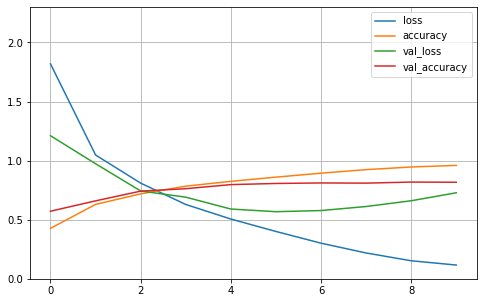

In [8]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2.3) # set the vertical range to [0-1]
plt.show()